In [1]:
from torchvision import datasets, transforms

transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

Training set size: 60000
Test set size: 10000
Number of classes: 10
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Image shape: torch.Size([1, 28, 28])


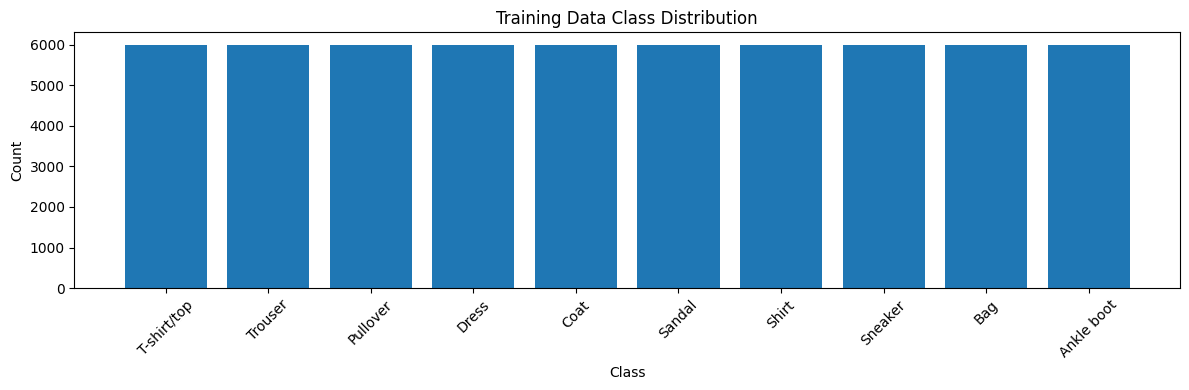

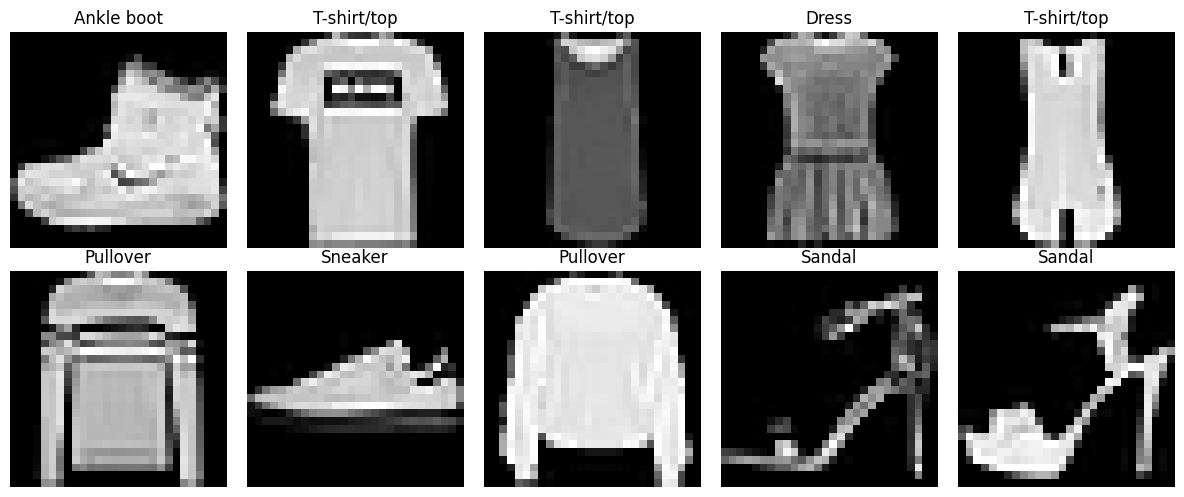

In [2]:
import numpy as np

import matplotlib.pyplot as plt

# Class labels for FashionMNIST
class_names = train_data.classes

# Dataset statistics
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}") 
print(f"Image shape: {train_data[0][0].shape}")

# Class distribution
train_labels = [label for _, label in train_data]
unique, counts = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(12, 4))
plt.bar([class_names[i] for i in unique], counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Training Data Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = train_data[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(class_names[label])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append('../src')
import model
import train
import torch.nn as nn

device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # For Apple Silicon GPUs
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# remove code to flatten if testing convolutional model
x_train_flattened = torch.flatten(train_data.data, start_dim=1).float() / 255.0
y_train = train_data.targets

x_test_flattened = torch.flatten(test_data.data, start_dim=1).float() / 255.0
y_test = test_data.targets

train_data_flattened = torch.utils.data.TensorDataset(x_train_flattened, y_train)
test_data_flattened = torch.utils.data.TensorDataset(x_test_flattened, y_test)

loss_histories = []
accuracy_histories = []

print(f"Flattened training data shape: {x_train_flattened.shape}")
print(f"Flattened test data shape: {x_test_flattened.shape}")

test_loader = DataLoader(test_data_flattened, batch_size=64, shuffle=False)

# Create validation set (10% of training data)
val_size = int(0.1 * len(train_data_flattened))
train_size = len(train_data_flattened) - val_size
train_data_split, val_data = torch.utils.data.random_split(train_data_flattened, [train_size, val_size])
train_loader = DataLoader(train_data_split, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

Flattened training data shape: torch.Size([60000, 784])
Flattened test data shape: torch.Size([10000, 784])


In [4]:
# hidden_layers = [1, 2]
# activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.ELU()]
# hidden_layer_sizes = [64, 128, 256, 512]
# optimizers = [torch.optim.Adam, torch.optim.AdamW, torch.optim.SGD]
# batch_norm_options = [False, True]
# dropout_probabilities = [0.0, 0.3, 0.5]

# for hl in hidden_layers:
#     for af in activation_functions:
#         for hls in hidden_layer_sizes:
#             for opt in optimizers:
#                 for bn in batch_norm_options:
#                     for dp in dropout_probabilities:
#                         print(f"Testing configuration: hidden_layers={hl}, activation_fn={af.__class__.__name__}, hidden_size={hls}, optimizer={opt.__name__}, batch_norm={bn}, dropout_prob={dp}")
#                         classifier = model.FashionClassifier(hidden_layers=hl, activation_fn=af, hidden_size=hls, dropout_prob=dp, batch_norm=bn)
#                         criterion = nn.CrossEntropyLoss()
#                         optimizer_instance = opt(classifier.parameters(), lr=0.001)
#                         classifier = classifier.to(device)
#                         loss_history, accuracy_history = train.train_model(classifier, train_loader, val_loader, criterion, optimizer_instance, epochs=5, device=device)
#                         test_accuracy = train.evaluate_model(classifier, test_loader, device=device)
#                         print(f"Test Accuracy: {test_accuracy:.4f}")
#                         loss_histories.append(loss_history)
#                         accuracy_histories.append(accuracy_history)


In [5]:
import re

# Regex patterns for parsing results.txt

# Pattern for configuration line
config_pattern = r'Testing configuration: hidden_layers=(\d+), activation_fn=(\w+), hidden_size=(\d+), optimizer=(\w+), batch_norm=(True|False), dropout_prob=([\d.]+)'

# Pattern for epoch line
epoch_pattern = r'Epoch \[(\d+)/(\d+)\] - Loss: ([\d.]+)'

# Pattern for accuracy line (training)
accuracy_pattern = r'^Accuracy: ([\d.]+)%$'

# Pattern for test accuracy line
test_accuracy_pattern = r'Test Accuracy: ([\d.]+)'

# Parse results and find top 5 configurations
results = []
current_config = None

with open('../results/results.txt', 'r') as f:
    for line in f:
        line = line.strip()
        
        if match := re.match(config_pattern, line):
            current_config = match.groups()
        elif match := re.match(test_accuracy_pattern, line):
            if current_config:
                test_acc = float(match.group(1))
                results.append((current_config, test_acc))

# Sort by test accuracy and get top 5
top_5_results = sorted(results, key=lambda x: x[1], reverse=True)[:5]

print("Top 5 Configurations by Test Accuracy:")
for i, (config, acc) in enumerate(top_5_results, 1):
    hidden_layers, activation_fn, hidden_size, optimizer, batch_norm, dropout_prob = config
    print(f"{i}. Test Accuracy: {acc:.4f} | layers={hidden_layers}, activation={activation_fn}, "
          f"size={hidden_size}, optimizer={optimizer}, batch_norm={batch_norm}, dropout={dropout_prob}")

Top 5 Configurations by Test Accuracy:
1. Test Accuracy: 87.9400 | layers=3, activation=ELU, size=512, optimizer=Adam, batch_norm=True, dropout=0.0
2. Test Accuracy: 87.8700 | layers=3, activation=ReLU, size=256, optimizer=Adam, batch_norm=False, dropout=0.0
3. Test Accuracy: 87.8200 | layers=2, activation=ReLU, size=256, optimizer=Adam, batch_norm=False, dropout=0.0
4. Test Accuracy: 87.6400 | layers=3, activation=ReLU, size=128, optimizer=Adam, batch_norm=True, dropout=0.0
5. Test Accuracy: 87.6300 | layers=2, activation=ELU, size=256, optimizer=AdamW, batch_norm=True, dropout=0.0


In [6]:
classifiers = []

print(f"Using device: {device}")

classifier1 = model.FashionClassifier(hidden_layers=3, activation_fn=nn.ELU(), hidden_size=512, batch_norm=True, dropout_prob=0.0) # change the model here to test other classifiers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier1.parameters(), lr=0.001)

classifier1 = classifier1.to(device)

classifier1_loss_history, classifier1_accuracy_history = train.train_model(classifier1, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)
classifier1_accuracy = train.evaluate_model(classifier1, test_loader, device=device)

loss_histories.append(classifier1_loss_history)
accuracy_histories.append(classifier1_accuracy_history)

classifiers.append(classifier1)

classifier2 = model.FashionClassifier(hidden_layers=3, activation_fn=nn.ReLU(), hidden_size=256, batch_norm=False, dropout_prob=0.0) # change the model here to test other classifiers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier2.parameters(), lr=0.001)


classifier2 = classifier2.to(device)

classifier2_loss_history, classifier2_accuracy_history = train.train_model(classifier2, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)
classifier2_accuracy = train.evaluate_model(classifier2, test_loader, device=device)

loss_histories.append(classifier2_loss_history)
accuracy_histories.append(classifier2_accuracy_history)

classifiers.append(classifier2)

classifier3 = model.FashionClassifier(hidden_layers=2, activation_fn=nn.ReLU(), hidden_size=256, batch_norm=False, dropout_prob=0.0) # change the model here to test other classifiers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier3.parameters(), lr=0.001)


classifier3 = classifier3.to(device)

classifier3_loss_history, classifier3_accuracy_history = train.train_model(classifier3, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)
classifier3_accuracy = train.evaluate_model(classifier3, test_loader, device=device)

loss_histories.append(classifier3_loss_history)
accuracy_histories.append(classifier3_accuracy_history)

classifiers.append(classifier3)

classifier4 = model.FashionClassifier(hidden_layers=3, activation_fn=nn.ReLU(), hidden_size=128, batch_norm=True, dropout_prob=0.0) # change the model here to test other classifiers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier4.parameters(), lr=0.001)

classifier4 = classifier4.to(device)

classifier4_loss_history, classifier4_accuracy_history = train.train_model(classifier4, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)
classifier4_accuracy = train.evaluate_model(classifier4, test_loader, device=device)

loss_histories.append(classifier4_loss_history)
accuracy_histories.append(classifier4_accuracy_history)

classifiers.append(classifier4)

classifier5 = model.FashionClassifier(hidden_layers=2, activation_fn=nn.ELU(), hidden_size=256, batch_norm=True, dropout_prob=0.0) # change the model here to test other classifiers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(classifier5.parameters(), lr=0.001)

classifier5 = classifier5.to(device)

classifier5_loss_history, classifier5_accuracy_history = train.train_model(classifier5, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)
classifier5_accuracy = train.evaluate_model(classifier5, test_loader, device=device)

loss_histories.append(classifier5_loss_history)
accuracy_histories.append(classifier5_accuracy_history)

classifiers.append(classifier5)

Using device: cuda
Epoch [1/5] - Loss: 0.3992
Accuracy: 85.62%
Epoch [2/5] - Loss: 0.3055
Accuracy: 86.58%
Epoch [3/5] - Loss: 0.2876
Accuracy: 87.05%
Epoch [4/5] - Loss: 0.3638
Accuracy: 87.62%
Epoch [5/5] - Loss: 0.2208
Accuracy: 88.80%
Accuracy: 88.35%
Epoch [1/5] - Loss: 0.5676
Accuracy: 85.47%
Epoch [2/5] - Loss: 0.3996
Accuracy: 86.47%
Epoch [3/5] - Loss: 0.5496
Accuracy: 87.27%
Epoch [4/5] - Loss: 0.4486
Accuracy: 87.13%
Epoch [5/5] - Loss: 0.5609
Accuracy: 87.52%
Accuracy: 87.14%
Epoch [1/5] - Loss: 0.3326
Accuracy: 85.10%
Epoch [2/5] - Loss: 0.3174
Accuracy: 87.13%
Epoch [3/5] - Loss: 0.3502
Accuracy: 87.77%
Epoch [4/5] - Loss: 0.3224
Accuracy: 88.17%
Epoch [5/5] - Loss: 0.4548
Accuracy: 88.62%
Accuracy: 87.76%
Epoch [1/5] - Loss: 0.5971
Accuracy: 85.27%
Epoch [2/5] - Loss: 0.3767
Accuracy: 87.43%
Epoch [3/5] - Loss: 0.3122
Accuracy: 87.47%
Epoch [4/5] - Loss: 0.5529
Accuracy: 88.12%
Epoch [5/5] - Loss: 0.3270
Accuracy: 87.75%
Accuracy: 87.11%
Epoch [1/5] - Loss: 0.2568
Accura

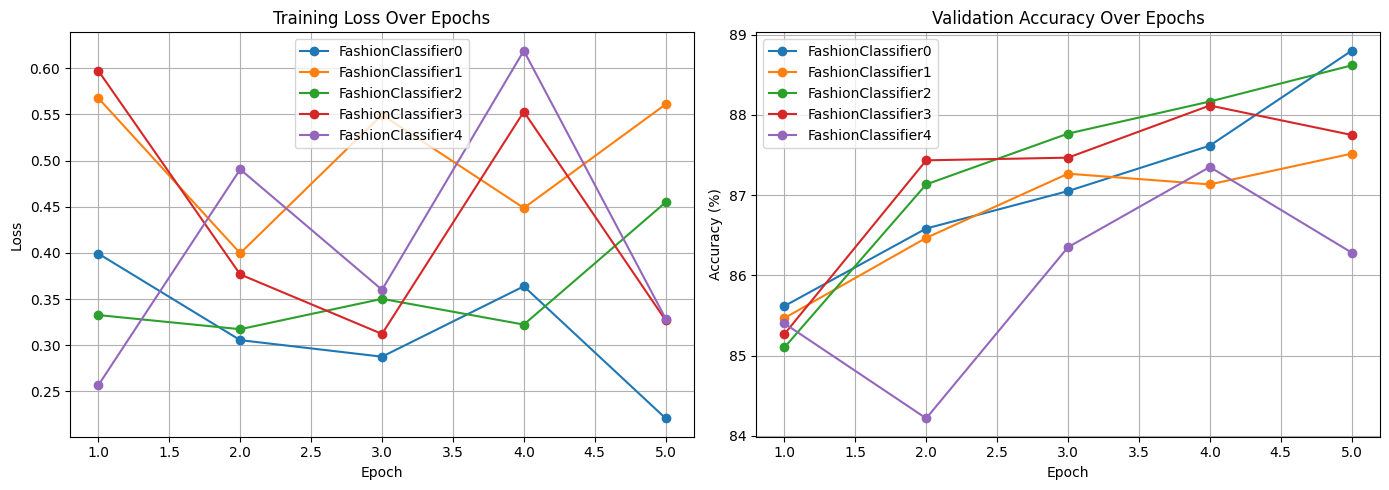

In [7]:
# Plot loss histories
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for i, loss_history in enumerate(loss_histories):
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label=f'FashionClassifier{i}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot accuracy histories
plt.subplot(1, 2, 2)
for i, accuracy_history in enumerate(accuracy_histories):
    plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', label=f'FashionClassifier{i}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

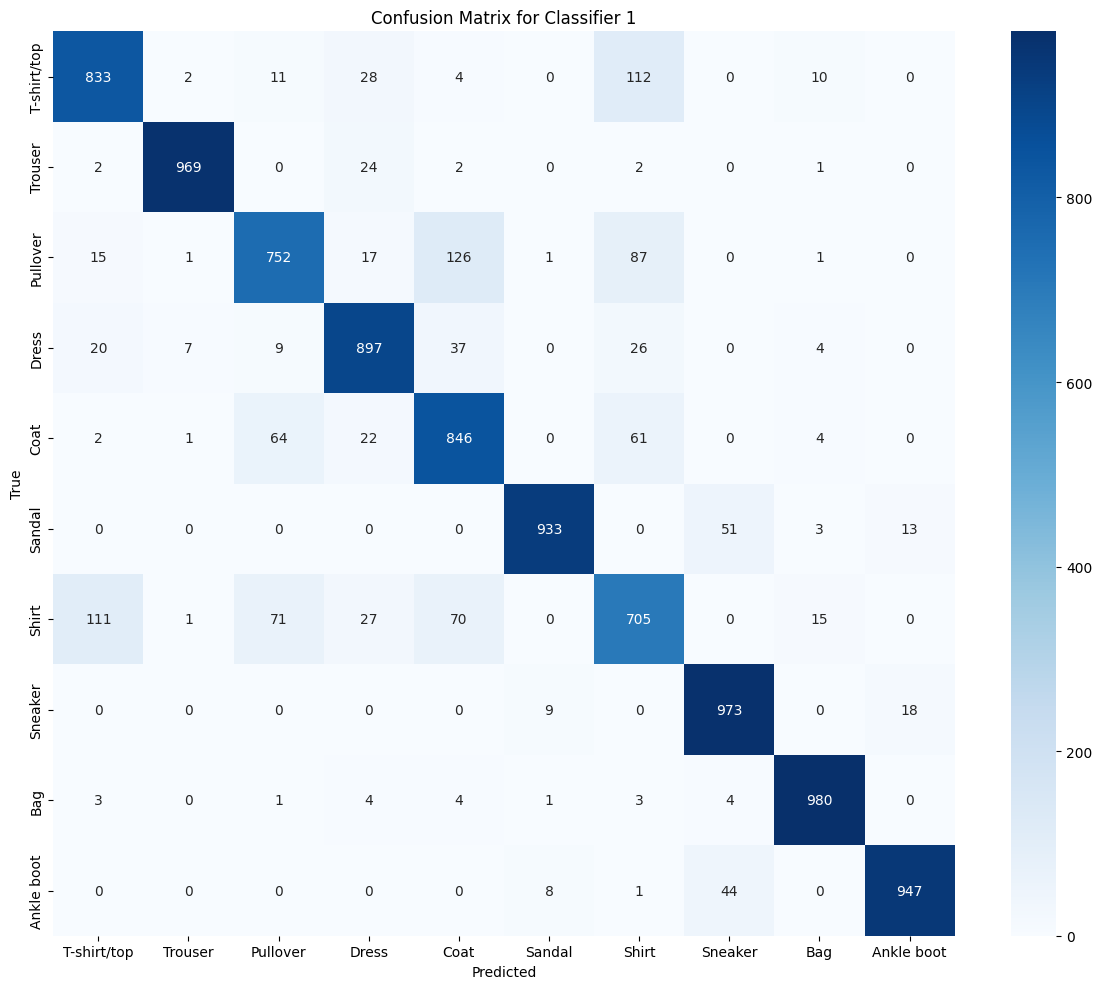

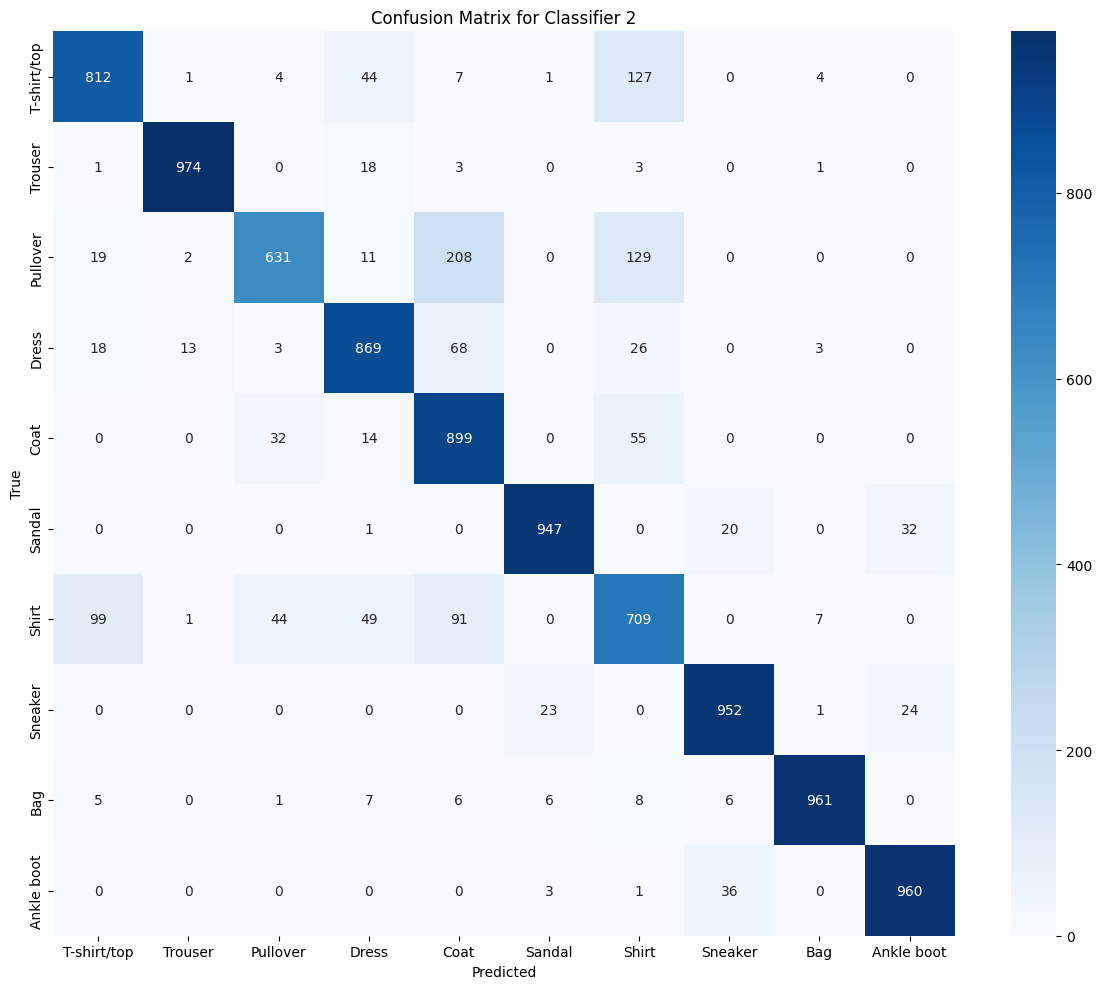

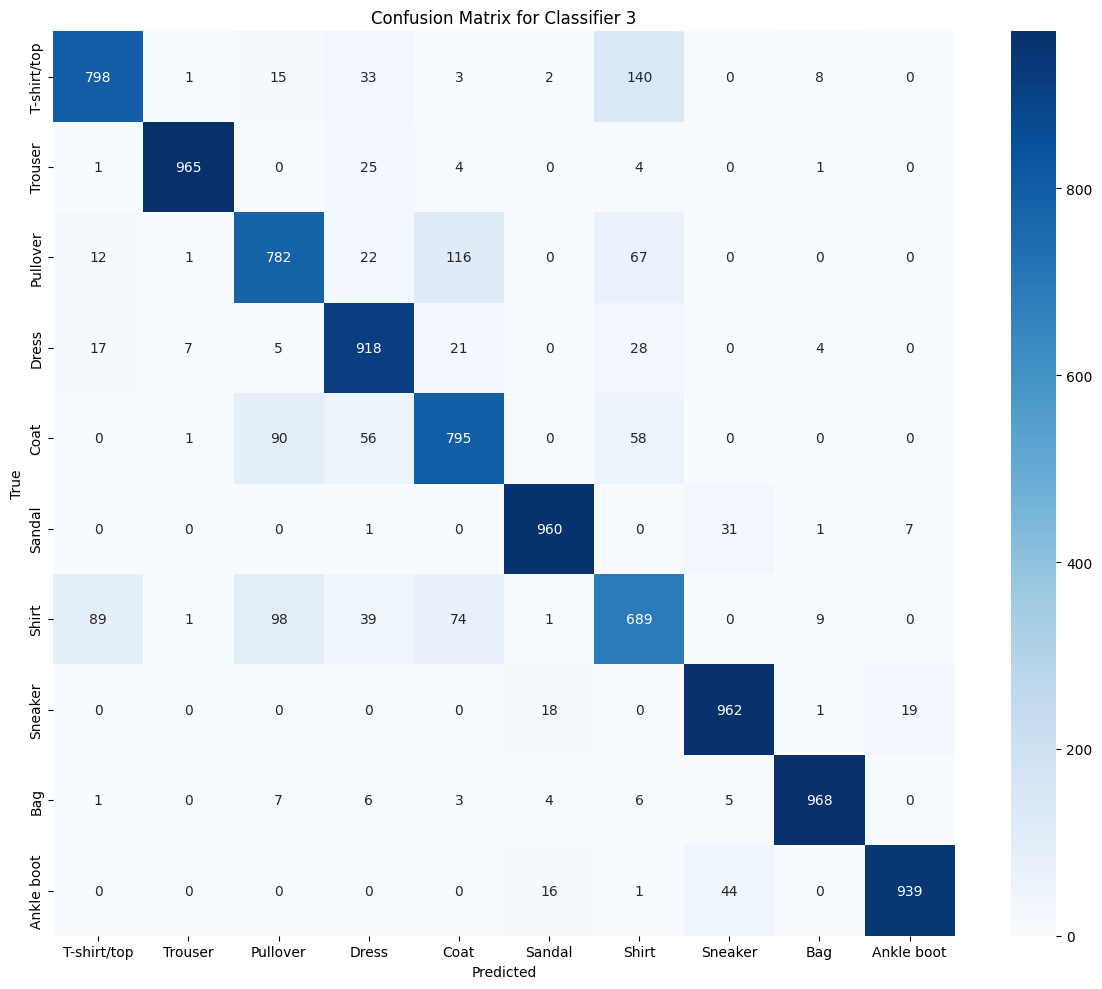

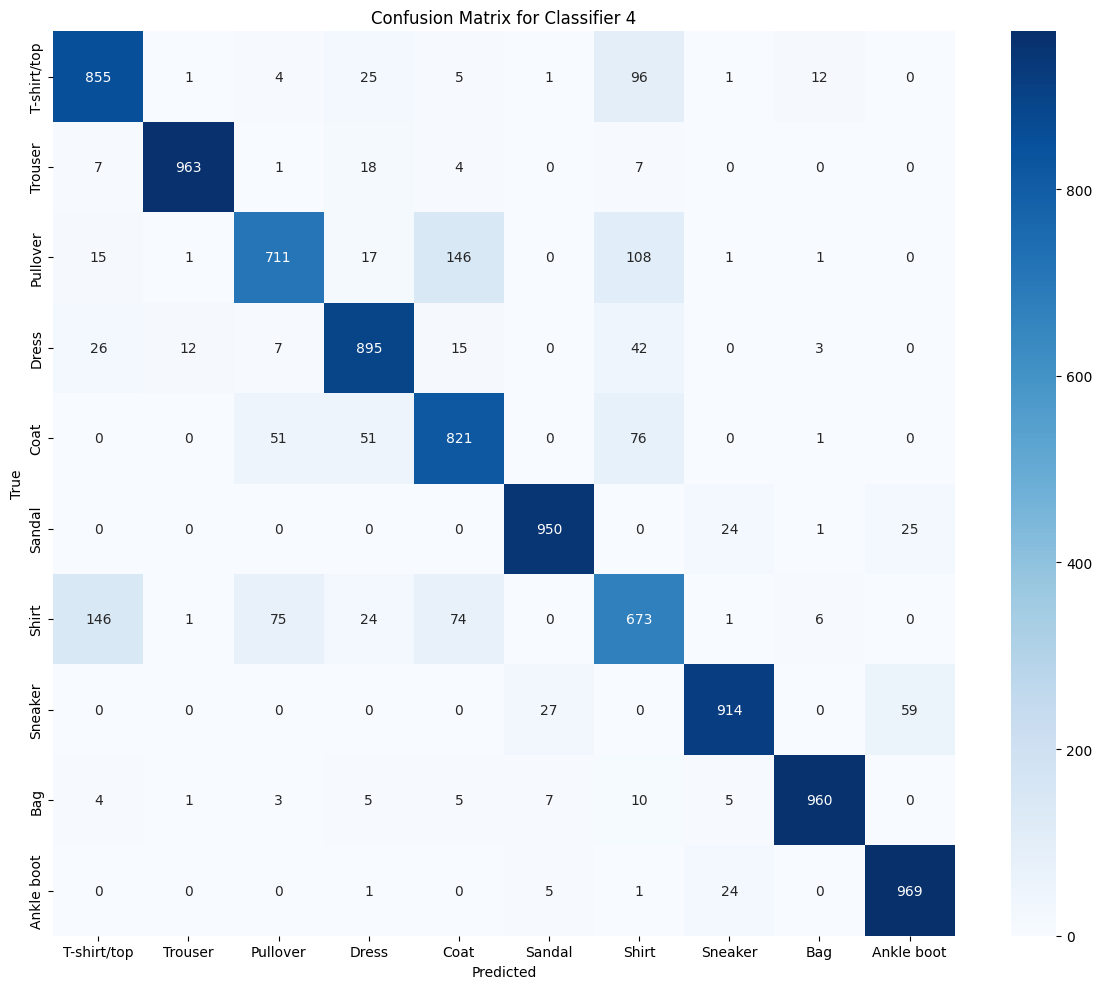

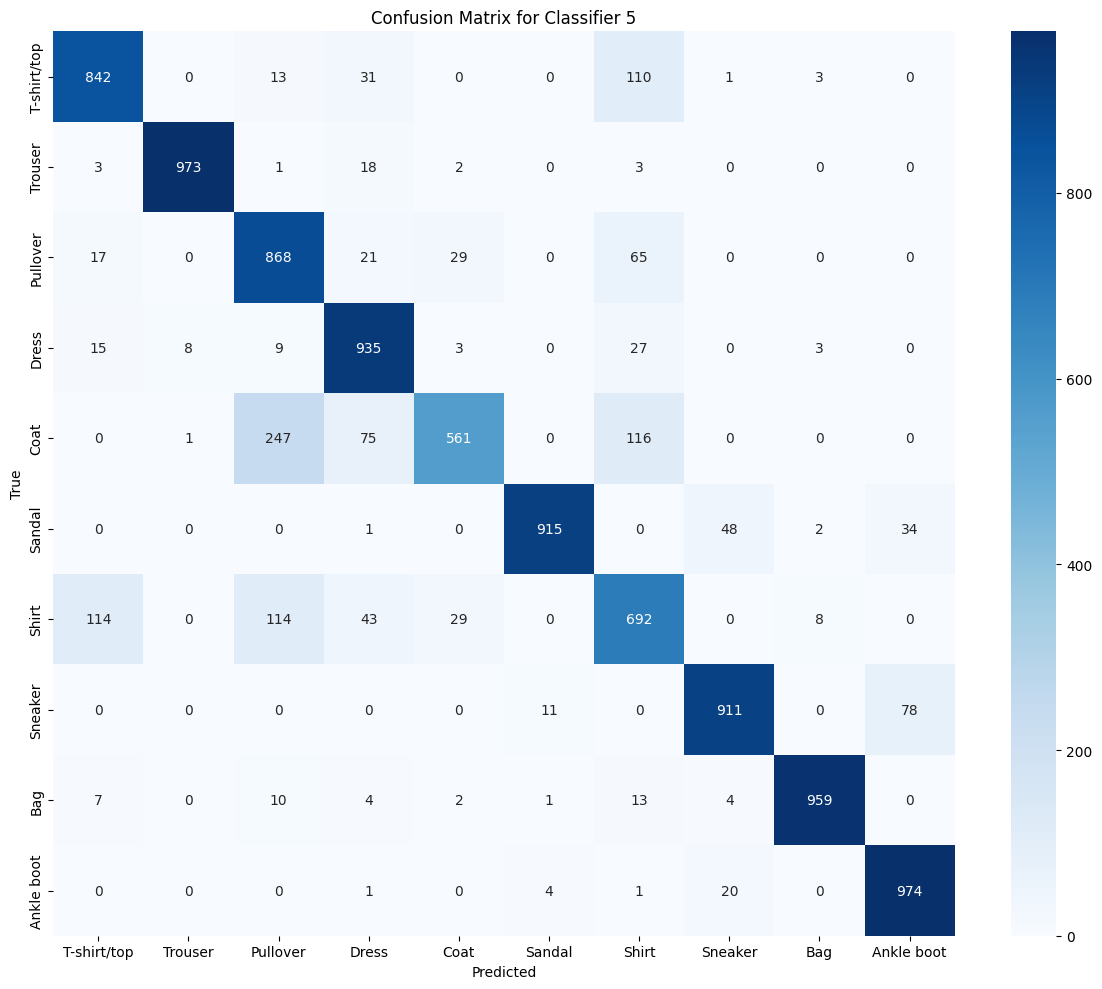

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


for i, classifier in enumerate(classifiers):
    # Get predictions on test set
    classifier.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = classifier(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Classifier {i+1}')
    plt.tight_layout()
    plt.show()

In [ ]:
# Create a cost matrix that penalizes certain misclassifications more heavily
cost_matrix = np.array([
    [0,             1,          1,          1,      1,      1,      3,      1,          1,      1],      # T-shirt/top
    [1,             0,          1,          1,      1,      1,      1,      1,          1,      1],      # Trouser
    [1,             1,          0,          1,      3,      1,      1,      1,          1,      1],      # Pullover
    [1,             1,          1,          0,      1,      1,      1,      1,          1,      1],      # Dress
    [1,             1,          3,          1,      0,      1,      1,      1,          1,      1],      # Coat
    [1,             1,          1,          1,      1,      0,      1,      2,          1,      1],      # Sandal
    [3,             1,          1,          1,      1,      1,      0,      1,          1,      1],      # Shirt
    [1,             1,          1,          1,      1,      2,      1,      0,          1,      2],      # Sneaker
    [1,             1,          1,          1,      1,      1,      1,      1,          0,      1],      # Bag
    [1,             1,          1,          1,      1,      1,      1,      2,          1,      0],      # Ankle boot
    #t-shirt/top,   trouser,    pullover,   dress,  coat,   sandal, shirt,  sneaker,    bag,    ankle boot
])

# Calculate standard and cost-weighted accuracy for each classifier
for i, classifier in enumerate(classifiers):
    classifier.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = classifier(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Standard accuracy
    standard_accuracy = np.mean(all_preds == all_labels) * 100
    
    # Cost-weighted accuracy: penalize incorrect predictions based on cost matrix
    total_cost = 0
    for true_label, pred_label in zip(all_labels, all_preds):
        total_cost += cost_matrix[true_label, pred_label]
    
    cost_weighted_accuracy = (1 - (total_cost / (len(all_labels) * np.max(cost_matrix)))) * 100
    
    print(f"Classifier {i+1}:")
    print(f"  Standard Accuracy: {standard_accuracy:.2f}%")
    print(f"  Cost-Weighted Accuracy: {cost_weighted_accuracy:.2f}%")
    print(f"  Total Cost: {total_cost}")
    print()

Classifier 1:
  Standard Accuracy: 88.35%
  Cost-Weighted Accuracy: 93.76%
  Total Cost: 1248

Classifier 2:
  Standard Accuracy: 87.14%
  Cost-Weighted Accuracy: 93.09%
  Total Cost: 1381

Classifier 3:
  Standard Accuracy: 87.76%
  Cost-Weighted Accuracy: 93.45%
  Total Cost: 1310

Classifier 4:
  Standard Accuracy: 87.11%
  Cost-Weighted Accuracy: 92.99%
  Total Cost: 1402

Classifier 5:
  Standard Accuracy: 86.30%
  Cost-Weighted Accuracy: 92.47%
  Total Cost: 1506

